In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.io as pio
import numpy as np
from dash import Dash, dcc, html, Input, Output


In [5]:
app = Dash(__name__)

file_path_main = 'City_Pipe_Main.csv'
city_pipe_main = pd.read_csv(file_path_main)

file_path_service = 'Service_Line_Table.csv'
service_line_table = pd.read_csv(file_path_service)

file_path_corrosion = 'Corrosion.csv'
Corrosion = pd.read_csv(file_path_corrosion)

file_path_simulated_corrosion = 'Corrosion_evaluated.csv'
Corrosion_evaluated = pd.read_csv(file_path_simulated_corrosion)

file_path_house = 'House_Information.csv'
house_information = pd.read_csv(file_path_house)

file_path_pipe_information = 'Pipe_Information.csv'
pipe_information = pd.read_csv(file_path_pipe_information)

file_path_state_of_water = 'State_of_Water.csv'
state_of_water = pd.read_csv(file_path_state_of_water)

city_pipe_main_valid = city_pipe_main.dropna(subset=['Latitude', 'Longitude'])
service_line_table_valid = service_line_table.dropna(subset=['Latitude', 'Longitude'])

In [6]:
def normalize(value, min_val, max_val):
    return (value - min_val) / (max_val - min_val)

def reset_corrosion_data():
    df_original = pd.read_csv(file_path_corrosion)
    
    df_original.to_csv(file_path_simulated_corrosion, index=False)

reset_corrosion_data()

df_original = pd.read_csv(file_path_simulated_corrosion)

def calculate_corrosion(corrosion_data, pipe_information, state_of_water, Y):
    corrosion_results = []

    for index, row in corrosion_data.iterrows():
        segment_id = row['SegmentID']
        old_rate = row['CorrosionRate']

        pipe_data = pipe_information[pipe_information['SegmentID'] == segment_id].iloc[0]
        water_data = state_of_water[state_of_water['SegmentID'] == segment_id].iloc[0]

        diameter = pipe_data['Diameter (cm)']
        soil = pipe_data['Soil']
        ph_value = abs(water_data['PH-Value'])
        psi_level = abs(water_data['PSI Level'])
        water_temp = abs(water_data['Water Temperature'])

        # Define material properties based on diameter
        if diameter == 30.48:
            mP, mPdev, F, mF, mFdev, fMax = 100, 100, 4700, 4700, 4700, 5405
        elif diameter == 4.1:
            mP, mPdev, F, mF, mFdev, fMax = 45, 85, 36.3, 36.3, 36.3, 41.75
        elif diameter == 3.5:
            mP, mPdev, F, mF, mFdev, fMax = 43, 87, 31, 31, 31, 35.7
        elif diameter == 2.7:
            mP, mPdev, F, mF, mFdev, fMax = 40, 90, 23.9, 23.9, 23.9, 27.49
        else:
            continue

        ranges = {
            "A": (0, 14), "P": (0, 130), "mP": (0, mP), "mPdev": (0, mPdev),
            "T": (5, 15), "X": (2.7, 30.48), "F": (0, fMax), "mF": (0, mF),
            "mFdev": (0, mFdev), "S": (0, 1)
        }

        A = normalize(ph_value, *ranges["A"])
        P = normalize(psi_level, *ranges["P"])
        mP = normalize(mP, *ranges["mP"])
        T = normalize(water_temp, *ranges["T"])
        X = normalize(diameter, *ranges["X"])
        F = normalize(F, *ranges["F"])
        mF = normalize(mF, *ranges["mF"])
        mFdev = normalize(mFdev, *ranges["mFdev"])
        S = 0.7 if soil == "Clay" else 0.4
        S = normalize(S, *ranges["S"])
        I = 0.5

        if pipe_data['Pipe Type'] == 'City Pipe Main':
            term1 = 0.16 * (0.3 + (A * (1 + 0.15)))
            term2 = 0.08 * (0.3 + (abs((P - mP)) * (0.6 + (1 / mPdev))))
            term3 = 0.16 * (T * (1 + 0.1))
            term4 = 0.08 * (X * (1 + 0.05))
        else:
            term1 = 0.16 * (0.3 + (A * (1 + 0.15)))
            term2 = 0.08 * (0.3 + (abs((P - mP)) * (1 + (1 / mPdev))))
            term3 = 0.16 * (T * (1 + 0.1))
            term4 = 0.08 * (X * (1 + 0.5))

        adjustment = 2.2 * Y * (term1 + term2 + term3 + term4)
        corrosion_rate = old_rate - adjustment

        if 80 <= corrosion_rate <= 100:
            corrosion_level = 1
        elif 60 <= corrosion_rate < 80:
            corrosion_level = 2
        elif 40 <= corrosion_rate < 60:
            corrosion_level = 3
        elif 20 <= corrosion_rate < 40:
            corrosion_level = 4
        elif 0 <= corrosion_rate < 20:
            corrosion_level = 5
        elif corrosion_rate > 100:
            corrosion_level = "Pipe Healed???"
        else:
            corrosion_level = "Pipe corroded."

        corrosion_results.append({
            "SegmentID": segment_id,
            "CorrosionRate": corrosion_rate,
            "CorrosionLevel": corrosion_level
        })


    # Convert the list of results to a DataFrame
    corrosion_results_df = pd.DataFrame(corrosion_results)

    # Set SegmentID as the index for both the Corrosion and the results DataFrame
    df_original.set_index('SegmentID', inplace=True)
    corrosion_results_df.set_index('SegmentID', inplace=True)

    # Update the original Corrosion_Evaluated DataFrame with the new results
    df_original.update(corrosion_results_df[['CorrosionRate', 'CorrosionLevel']])

    # Reset the index for both DataFrames
    df_original.reset_index(inplace=True)

    # Save the updated Corrosion_Evaluated DataFrame to a CSV file
    df_original.to_csv("Corrosion_evaluated.csv", index=False)

    #Display the first 100 rows of the updated corrosion results
    corrosion_results_df.head(100)
    return pd.DataFrame(corrosion_results_df)

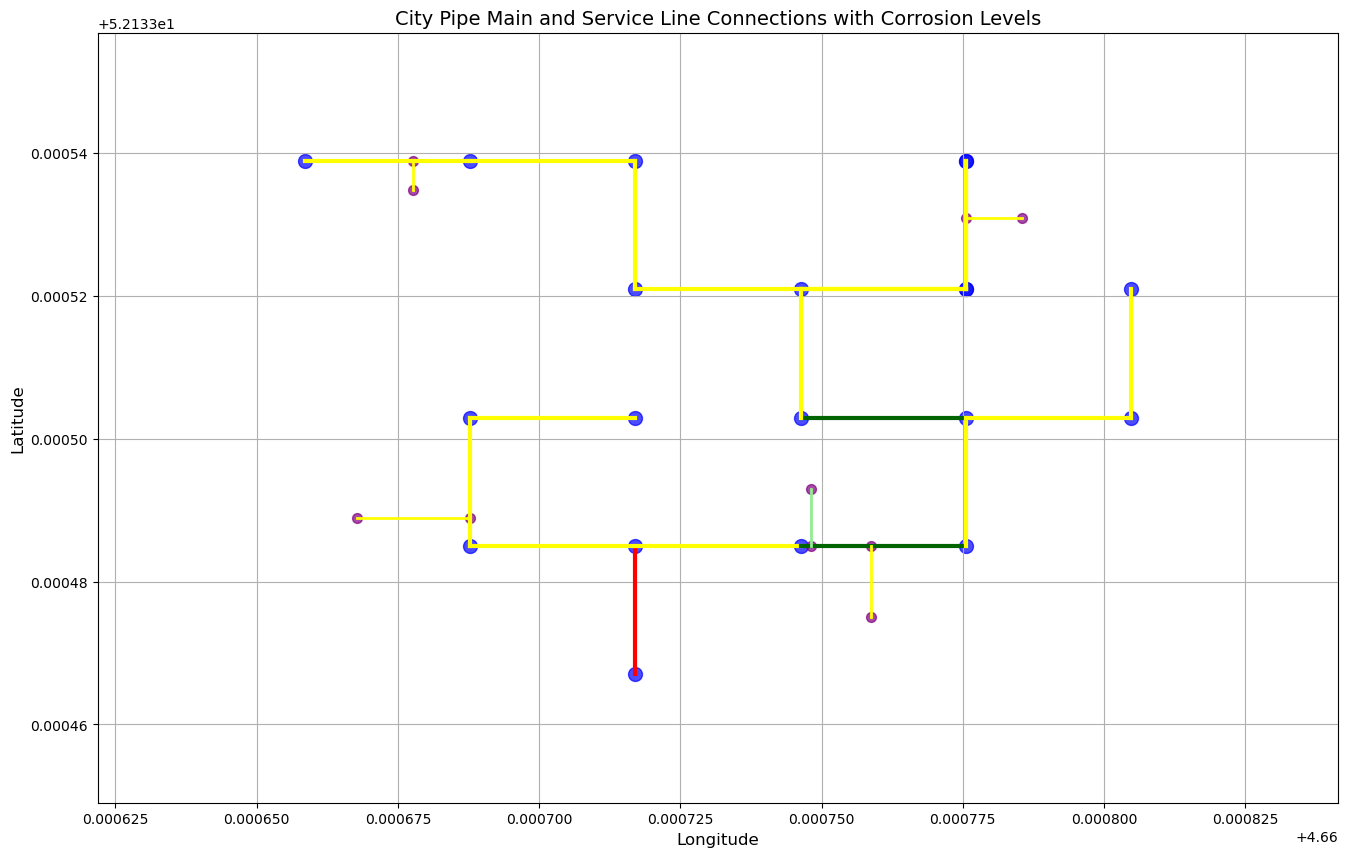

In [8]:
# Define colors for corrosion levels
corrosion_colors = {
    1: 'darkgreen',
    2: 'lightgreen',
    3: 'yellow',
    4: 'orange',
    5: 'red'
}

CEval = pd.read_csv('Corrosion_evaluated.csv')

# Map corrosion levels
corrosion_map = CEval.set_index('SegmentID')['CorrosionLevel'].to_dict()

# Prepare city pipe main data
city_edges = []
city_positions = {}

for _, row in city_pipe_main.iterrows():
    city_positions[row['SegmentID']] = (row['Longitude'], row['Latitude'])
    if pd.notna(row['Parent Pipe']):
        parent_row = city_pipe_main[city_pipe_main['SegmentID'] == row['Parent Pipe']]
        if not parent_row.empty:
            parent_lat, parent_lon = parent_row.iloc[0]['Latitude'], parent_row.iloc[0]['Longitude']
            corrosion_level = corrosion_map.get(row['SegmentID'], None)
            color = corrosion_colors.get(corrosion_level, 'gray')  # Default to gray if no corrosion level
            city_edges.append(((parent_lon, parent_lat), (row['Longitude'], row['Latitude']), color))

# Prepare service line data
service_edges = []
service_positions = {}

for _, row in service_line_table.iterrows():
    service_positions[row['SegmentID']] = (row['Longitude'], row['Latitude'])
    if pd.notna(row['ParentPipe']):
        parent_row = service_line_table[service_line_table['SegmentID'] == row['ParentPipe']]
        if not parent_row.empty:
            parent_lat, parent_lon = parent_row.iloc[0]['Latitude'], parent_row.iloc[0]['Longitude']
            corrosion_level = corrosion_map.get(row['SegmentID'], None)
            color = corrosion_colors.get(corrosion_level, 'gray')  # Default to gray if no corrosion level
            service_edges.append(((parent_lon, parent_lat), (row['Longitude'], row['Latitude']), color))

# Calculate map boundaries
combined_latitudes = pd.concat([city_pipe_main['Latitude'], service_line_table['Latitude']])
combined_longitudes = pd.concat([city_pipe_main['Longitude'], service_line_table['Longitude']])

center_lon = (combined_longitudes.max() + combined_longitudes.min()) / 2
center_lat = (combined_latitudes.max() + combined_latitudes.min()) / 2
lon_range = combined_longitudes.max() - combined_longitudes.min()
lat_range = combined_latitudes.max() - combined_latitudes.min()
zoom_factor = 1.5

# Plot the data
plt.figure(figsize=(16, 10))

for edge in city_edges:
    x_coords = [edge[0][0], edge[1][0]]
    y_coords = [edge[0][1], edge[1][1]]
    plt.plot(x_coords, y_coords, color=edge[2], linewidth=3, label='City Pipe Main Edge')

for edge in service_edges:
    x_coords = [edge[0][0], edge[1][0]]
    y_coords = [edge[0][1], edge[1][1]]
    plt.plot(x_coords, y_coords, color=edge[2], linewidth=2, label='Service Line Edge')

for node, (lon, lat) in city_positions.items():
    plt.scatter(lon, lat, s=100, alpha=0.7, color='blue', label='City Pipe Main Node')

for node, (lon, lat) in service_positions.items():
    plt.scatter(lon, lat, s=50, alpha=0.7, color='purple', label='Service Line Node')

plt.xlabel("Longitude", fontsize=12)
plt.ylabel("Latitude", fontsize=12)
plt.title("City Pipe Main and Service Line Connections with Corrosion Levels", fontsize=14)

plt.xlim(center_lon - (lon_range / 2 * zoom_factor), center_lon + (lon_range / 2 * zoom_factor))
plt.ylim(center_lat - (lat_range / 2 * zoom_factor), center_lat + (lat_range / 2 * zoom_factor))

plt.grid(True)
plt.show()


In [11]:
# Create layout with slider
app.layout = html.Div([
    dcc.Slider(
        id='year-slider',
        min=1,
        max=80,
        value=0,
        marks={i: str(i) for i in range(0, 80, 10)},
        step=1
    ),
    dcc.Graph(id='corrosion-map')
])

@app.callback(
    Output('corrosion-map', 'figure'),
    Input('year-slider', 'value')
)
def update_map(Y):
    corrosion_results = calculate_corrosion(Corrosion, pipe_information, state_of_water, Y)
    merged_data = pd.merge(city_pipe_main, corrosion_results, on='SegmentID', how='left')

    fig = go.Figure()

    # Add nodes and edges
    for _, row in merged_data.iterrows():
        color = 'blue' if row['CorrosionLevel'] == 1 else 'gray'  # Example color mapping
        fig.add_trace(go.Scattermapbox(
            lon=[row['Longitude']],
            lat=[row['Latitude']],
            mode='markers',
            marker=dict(size=10, color=color),
            text=f"Rate: {row['CorrosionRate']}<br>Level: {row['CorrosionLevel']}",
            hoverinfo='text'
        ))

    fig.update_layout(
        mapbox_style="open-street-map",
        mapbox_center={"lon": merged_data['Longitude'].mean(), "lat": merged_data['Latitude'].mean()},
        mapbox_zoom=12,
        title=f"Corrosion Map for Year {Y}"
    )
    return fig

if __name__ == '__main__':
    app.run_server(debug=True, port=8051)